<a href="https://colab.research.google.com/github/agalvezm/ACE2_scRNAseq/blob/master/notebooks_countmatrices/GSE117824_GSM3739218.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GSE117824_GSM3739218

In [1]:
# Install SRA-toolkit 
!wget "http://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz"

! tar -xzf sratoolkit.current-centos_linux64.tar.gz

# Add to path
import os
os.environ['PATH'] += ":/content/sratoolkit.2.11.0-centos_linux64/bin"

# Configure
!vdb-config --interactive

# Import packages

import numpy as np

--2021-03-23 22:10:35--  http://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz
Resolving ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)... 165.112.9.230, 130.14.250.7, 2607:f220:41e:250::13, ...
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|165.112.9.230|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz [following]
--2021-03-23 22:10:35--  https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|165.112.9.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99139357 (95M) [application/x-gzip]
Saving to: ‘sratoolkit.current-centos_linux64.tar.gz’

sratoolkit.current- 100%[===================>]  94.55M   180MB/s    in 0.5s    

2021-03-23 22:10:36 (180 MB/s) - ‘

In [2]:
# List of SRAs to download and transform. Copy paste from excel as string
SRAs = "SRR8987929	SRR8987930	SRR8987931	SRR8987932"

SRAs = SRAs.split()

# SRA to delete, usually the index file, which get downloaded because we include technical reads. 
# It varies so check in the SRA website
SRA_to_delete = "3"


SRAs_to_keep = np.setdiff1d(["1", "2", "3"], [SRA_to_delete])

In [3]:
for sra in SRAs:
  """
  Downloads SRAs and transforms to compressed fastq file. Remove index reads and original SRA
  """
  # Download SRA
  !prefetch $sra

  # Convert to fastq. Biological reads are usually considered technicals in 10x so do not skip them.
  fastq_dump_cmd = "fastq-dump -F --gzip --readids --split-files " + sra + "/" + sra +".sra"
  !$fastq_dump_cmd

  # Remove files
  rm_cmd_1 = "rm " + sra + "/" + sra + ".sra"
  rm_cmd_2 = "rm " + sra + "_" + SRA_to_delete + ".fastq.gz" 
  !$rm_cmd_1
  !$rm_cmd_2


2021-03-23T22:11:44 prefetch.2.11.0: 1) Downloading 'SRR8987929'...
2021-03-23T22:11:44 prefetch.2.11.0:  Downloading via HTTPS...
2021-03-23T22:13:27 prefetch.2.11.0:  HTTPS download succeed
2021-03-23T22:13:36 prefetch.2.11.0:  'SRR8987929' is valid
2021-03-23T22:13:36 prefetch.2.11.0: 1) 'SRR8987929' was downloaded successfully
2021-03-23T22:13:36 prefetch.2.11.0: 'SRR8987929' has 0 unresolved dependencies
Read 48400647 spots for SRR8987929/SRR8987929.sra
Written 48400647 spots for SRR8987929/SRR8987929.sra

2021-03-23T23:11:22 prefetch.2.11.0: 1) Downloading 'SRR8987930'...
2021-03-23T23:11:22 prefetch.2.11.0:  Downloading via HTTPS...
2021-03-23T23:13:07 prefetch.2.11.0:  HTTPS download succeed
2021-03-23T23:13:17 prefetch.2.11.0:  'SRR8987930' is valid
2021-03-23T23:13:17 prefetch.2.11.0: 1) 'SRR8987930' was downloaded successfully
2021-03-23T23:13:17 prefetch.2.11.0: 'SRR8987930' has 0 unresolved dependencies
Read 49165847 spots for SRR8987930/SRR8987930.sra
Written 49165847 sp

In [4]:
# Define fastq list to feed kb

fastqs = []
for sra in SRAs:
  for read in SRAs_to_keep:
    fastqs.append(sra + "_" + read + ".fastq.gz")

In [5]:
# define the values for the analysis

# accession id for the data
id = "GSE117824"
samp_id = ["GSM3739218"]

# If only bam available files, set bam = True, Fill link and filename
bam = False

fastq_ffqlinks = False


In [6]:
no_samples = 1

fastqs_per_sample = [2, 8, 8] 

sample_id = samp_id

database_id = [id] * no_samples

tissue = ["bone marrow"] * no_samples

cell_type = ["CD34+ bone marrow mononuclear cells (BMMCs)"] * no_samples

condition = ["diagnosis ET, age 17"] * no_samples

species = ["human"] * no_samples

technology = ["10xv2"] * no_samples

paper = ["Muus et al 2020"] * no_samples

figure = ["Fig 1 a,b  ED Fig 1 a,b,c,d  ED Fig 2 a,b,c,d,e"] * no_samples


# Set string variables for kb functions

species_kb = species[0]

technology_kb = technology[0]



# Imports and installs

In [7]:
# install and import necessary software

# Install kb and scanpy
!pip -q install kb-python 
!pip -q install scanpy

import re
import os

# Setup

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

     |████████████████████████████████| 59.1MB 76kB/s 
     |████████████████████████████████| 122kB 21.3MB/s 
     |████████████████████████████████| 10.3MB 29.8MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 13.2MB 328kB/s 
     |████████████████████████████████| 112kB 44.0MB/s 
     |████████████████████████████████| 71kB 5.9MB/s 
     |████████████████████████████████| 51kB 4.1MB/s 


In [8]:
!kb ref -d $species_kb -i index.idx -g t2g.txt -f1 transcriptome.fasta

[2021-03-24 01:17:04,885]    INFO Downloading files for human from https://caltech.box.com/shared/static/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz to tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
100% 2.23G/2.23G [01:32<00:00, 25.9MB/s]
[2021-03-24 01:18:38,696]    INFO Extracting files from tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz


# Process fastq files (modify kb command according to fastqs list)


In [9]:
fastqs = sorted(fastqs)
fastqs

['SRR8987929_1.fastq.gz',
 'SRR8987929_2.fastq.gz',
 'SRR8987930_1.fastq.gz',
 'SRR8987930_2.fastq.gz',
 'SRR8987931_1.fastq.gz',
 'SRR8987931_2.fastq.gz',
 'SRR8987932_1.fastq.gz',
 'SRR8987932_2.fastq.gz']

In [10]:


if no_samples == 1:

  # Write the kb count command as a string with all fastqs of the list as an input
  cmd = "kb count --h5ad -i index.idx -g t2g.txt -x " + technology_kb + " -o output" + sample_id[0] + " "\
  + "--filter bustools -t 2 --overwrite " + "'" +  "' '".join(fastqs) + "'"
  
  # Execute it
  !$cmd

# If more than one sample, iterate through fastqs accordingly
else:

  # Initializa counter for fastq files
  j = 0

  # Loop over samples for analysis
  for i in range(no_samples):

    fastqs_to_analyze = fastqs[j:j + fastqs_per_sample[i]]
    # Write the kb count command as a string
    cmd = "kb count --h5ad -i ../index.idx -g ../t2g.txt -x " + technology_kb + " -o output" + sample_id[i] + " \
    --filter bustools -t 2 --overwrite " + "'" +  "' '".join(fastqs_to_analyze) + "'"

    # Execute it
    !$cmd

    # Update j to move to the next set of fastq
    j = j + fastqs_per_sample[i]







[2021-03-24 01:19:19,529]    INFO Using index index.idx to generate BUS file to outputGSM3739218 from
[2021-03-24 01:19:19,530]    INFO         SRR8987929_1.fastq.gz
[2021-03-24 01:19:19,530]    INFO         SRR8987929_2.fastq.gz
[2021-03-24 01:19:19,530]    INFO         SRR8987930_1.fastq.gz
[2021-03-24 01:19:19,530]    INFO         SRR8987930_2.fastq.gz
[2021-03-24 01:19:19,530]    INFO         SRR8987931_1.fastq.gz
[2021-03-24 01:19:19,530]    INFO         SRR8987931_2.fastq.gz
[2021-03-24 01:19:19,530]    INFO         SRR8987932_1.fastq.gz
[2021-03-24 01:19:19,530]    INFO         SRR8987932_2.fastq.gz
[2021-03-24 01:24:04,201]   ERROR 
[index] k-mer length: 31
[index] number of targets: 227,368
[index] number of k-mers: 140,125,185
tcmalloc: large alloc 6442450944 bytes == 0x23c6000 @  0x7f3f2d533887 0x457d7f 0x451662 0x42732d 0x7f3f2c1abbf7 0x42c2c5
[index] number of equivalence classes: 964,094
[quant] will process sample 1: SRR8987929_1.fastq.gz
SRR8987929_2.fastq.gz
[quant] wi

# Load unfiltered matrix and assign filters to each matrix individually

## Load the unfiltered matrix (check dimensions)

In [ ]:
import time
time.sleep(600000)

In [ ]:
# Define dict to store data
results = {}


In [ ]:
# load the unfiltered matrix
for i in range(no_samples):
  results[sample_id[i]] = anndata.read_h5ad("output" + sample_id[i] + "/counts_unfiltered/adata.h5ad")
  results[sample_id[i]].var["gene_id"] = results[sample_id[i]].var.index.values

  t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
  t2g.index = t2g.gene_id
  t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

  results[sample_id[i]].var["gene_name"] = results[sample_id[i]].var.gene_id.map(t2g["gene_name"])
  results[sample_id[i]].var.index = results[sample_id[i]].var["gene_name"]
  print("The unfiltered matrix " + sample_id[i] + " contains {} cells by {} genes".format(len(results[sample_id[i]].obs), len(results[sample_id[i]].var)))

  results[sample_id[i]].obs["cell_counts"] = results[sample_id[i]].X.sum(axis=1)
  results[sample_id[i]].var["gene_counts"] = nd(results[sample_id[i]].X.sum(axis=0))

  results[sample_id[i]].obs["n_genes"] = nd((results[sample_id[i]].X>0).sum(axis=1))
  results[sample_id[i]].var["n_cells"] = nd((results[sample_id[i]].X>0).sum(axis=0))

  mito_genes = results[sample_id[i]].var_names.str.startswith("MT-" or "mt-") 
  results[sample_id[i]].obs["percent_mito"] = results[sample_id[i]][:,mito_genes].X.sum(axis=1)/results[sample_id[i]].X.sum(axis=1)*100

  # Changing the name of the index is necessary to write the file (it won't work with duplicated names)
  results[sample_id[i]].var.index.name = "index"



The unfiltered matrix GSM3739217 contains 307422 cells by 60623 genes
The unfiltered matrix GSM3739218 contains 38175 cells by 60623 genes
The unfiltered matrix GSM3739219 contains 35956 cells by 60623 genes


## Assign filters for each matrix individually

In [ ]:
# Modify this manually to change sample after having assigned the "expected_num_cells" and "mito_criteria" parameters
samp_n = 1

# Filtering criteria
cell_threshold = 100
gene_threshold = 3

mito_criteria = 30

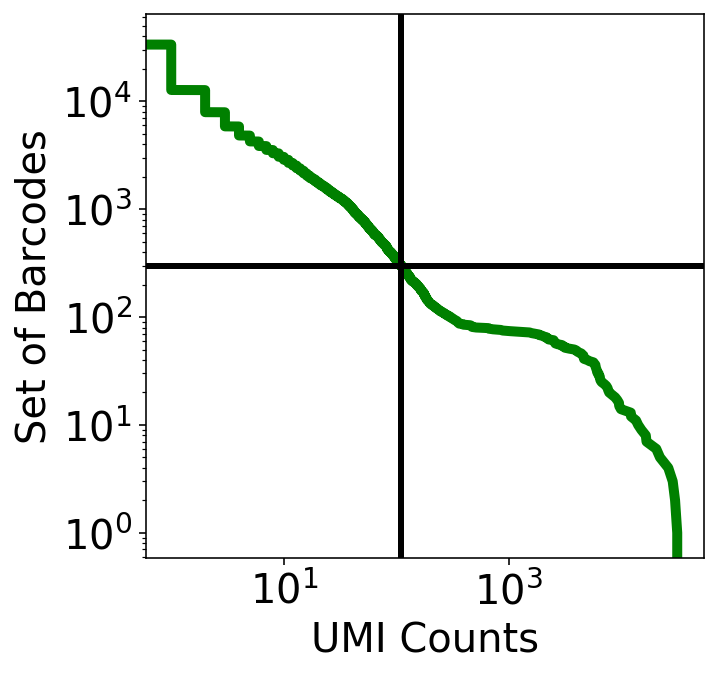

Cells were filtered down to 300 with at least 111.0 UMIs


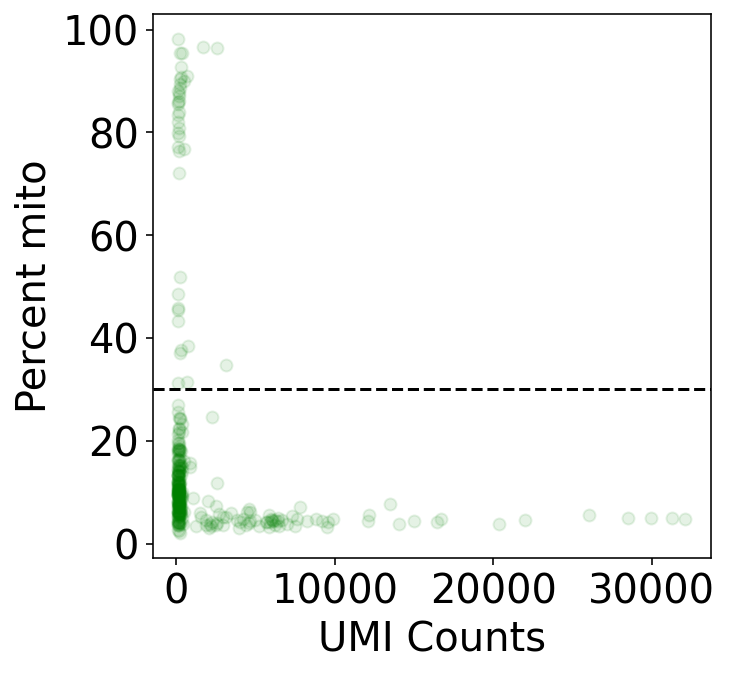

We select 30 % as the mitochondrial content threshold


In [ ]:

expected_num_cells = 300#@param {type:"integer"}
knee = np.sort(nd(results[sample_id[samp_n]].X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.show()

cell_threshold = knee[expected_num_cells]

results["cell_threshold" + sample_id[samp_n]] = knee[expected_num_cells]

print ("Cells were filtered down to " + str(expected_num_cells) + " with at least " + str(cell_threshold) + " UMIs")


mito_criteria = 30#@param {type:"integer"}
results["mito_criteria" + sample_id[samp_n]] = mito_criteria

fig, ax = plt.subplots(figsize=(5,5))


x = nd(results[sample_id[samp_n]].obs["cell_counts"][results[sample_id[samp_n]].obs["cell_counts"] > cell_threshold])
y = nd(results[sample_id[samp_n]].obs["percent_mito"][results[sample_id[samp_n]].obs["cell_counts"] > cell_threshold])

ax.scatter(x, y, color="green", alpha=0.1)

ax.axhline(y=mito_criteria, linestyle="--", color="k")


ax.set_xlabel("UMI Counts")
ax.set_ylabel("Percent mito")


plt.show()

print("We select " + str(mito_criteria) + " % as the mitochondrial content threshold")

# Filter matrix

In [ ]:
for i in range(no_samples):
  results[sample_id[i]].obs["pass_count_filter"] = results[sample_id[i]].obs["cell_counts"] > results["cell_threshold" + sample_id[i]]
  results[sample_id[i]].obs["pass_mito_filter"] = results[sample_id[i]].obs.percent_mito < results["mito_criteria" + sample_id[i]]
  results[sample_id[i]].var["pass_gene_filter"] = results[sample_id[i]].var["n_cells"] > gene_threshold

  cell_mask = np.logical_and(results[sample_id[i]].obs["pass_count_filter"].values, results[sample_id[i]].obs["pass_mito_filter"].values)
  gene_mask = results[sample_id[i]].var["pass_gene_filter"].values

  print("Current Shape: {:,} cells x {:,} genes".format(results[sample_id[i]].shape[0], results[sample_id[i]].shape[1]))
  print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))
  results["data_" + sample_id[i]] = results[sample_id[i]][cell_mask, gene_mask]

Current Shape: 307,422 cells x 60,623 genes
    New shape: 7,021 cells x 25,624 genes
Current Shape: 38,175 cells x 60,623 genes
    New shape: 258 cells x 11,159 genes
Current Shape: 35,956 cells x 60,623 genes
    New shape: 274 cells x 11,378 genes


# Anotate and write the Anndata object

In [ ]:
for i in range(no_samples):


  results["data_" + sample_id[i]].uns["database_id"] = database_id[samp_n]

  results["data_" + sample_id[i]].uns["tissue"] = tissue[samp_n]

  results["data_" + sample_id[i]].uns["cell_type"] = cell_type[samp_n]

  results["data_" + sample_id[i]].uns["sample_id"] = sample_id[samp_n]

  results["data_" + sample_id[i]].uns["condition"] = condition[samp_n]

  results["data_" + sample_id[i]].uns["species"] = species[samp_n]

  results["data_" + sample_id[i]].uns["technology"] = technology[samp_n]

  results["data_" + sample_id[i]].uns["paper"] = paper[samp_n]

  results["data_" + sample_id[i]].uns["figure"] = figure[samp_n]

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [ ]:
%cd /content

for i in range(no_samples):

  results["data_" + sample_id[i]].write("result" + sample_id[i])

/content


... storing 'gene_name' as categorical
... storing 'gene_name' as categorical
... storing 'gene_name' as categorical
